# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-libraries" data-toc-modified-id="Load-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load libraries</a></div><div class="lev1 toc-item"><a href="#Define-loss-functions" data-toc-modified-id="Define-loss-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define loss functions</a></div><div class="lev1 toc-item"><a href="#Define-models" data-toc-modified-id="Define-models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define models</a></div><div class="lev1 toc-item"><a href="#Training" data-toc-modified-id="Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training</a></div><div class="lev1 toc-item"><a href="#Predictions" data-toc-modified-id="Predictions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Predictions</a></div>

# Load libraries

In [1]:
import cv2
import numpy as np
import pandas as pd

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.losses import binary_crossentropy
import keras.backend as K

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Define loss functions

In [2]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + (1 - dice_loss(y_true, y_pred))

# Define models

In [3]:
def unet_down_one_block(inputs, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [4]:
def unet_max_pool(inputs):
    x = MaxPooling2D((2, 2), strides=(2, 2))(inputs)
    return x

In [5]:
def unet_up_one_block(up_input, down_input, num_filters):
    x = UpSampling2D((2,2))(up_input)
    x = concatenate([down_input, x], axis=3)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [6]:
def get_unet(input_shape = (256, 256, 3),
             num_classes = 1,
             initial_filters = 32,
             central_filters = 1024):
    
    num_filters = initial_filters
    
    out_list    = [Input(shape=input_shape)]
    down_interim_list = []
    
    while num_filters <= central_filters/2:
        x = unet_down_one_block(out_list[-1], num_filters)
        down_interim_list.append(x)
        num_filters = num_filters * 2
        y = unet_max_pool(x)
        out_list.append(y)
    
    x = unet_down_one_block(out_list[-1], num_filters)
    out_list.append(x)
    num_filters = int(num_filters / 2)
    
    while num_filters >= initial_filters:
        x = unet_up_one_block(out_list[-1], down_interim_list.pop(), num_filters)
        out_list.append(x)
        num_filters = int(num_filters / 2)
    
    classify = Conv2D(num_classes, (1,1), activation = 'sigmoid')(out_list[-1])
    
    model = Model(inputs=out_list[0], outputs=classify)
    
    model.compile(optimizer=RMSprop(lr=0.0001),
                  loss=bce_dice_loss,
                  metrics=[dice_loss])
    
    return model

In [7]:
model = get_unet(input_shape=(1024,1024,3), initial_filters=8)

In [8]:
model.load_weights('./weights/best_weights_1024.hdf5')

# Training

In [9]:
max_epochs = 50
threshold  = 0.5

In [10]:
df_train = pd.read_csv('data/train_masks.csv')

In [11]:
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

In [12]:
ids_train_split, ids_valid_split = train_test_split(ids_train, test_size=0.2, random_state=42)

In [13]:
def randomHueSaturationValue(image, hue_shift_limit=(-180, 180),
                             sat_shift_limit=(-255, 255),
                             val_shift_limit=(-255, 255), u=0.5):
    if np.random.random() < u:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(image)
        hue_shift = np.random.uniform(hue_shift_limit[0], hue_shift_limit[1])
        h = cv2.add(h, hue_shift)
        sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
        s = cv2.add(s, sat_shift)
        val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
        v = cv2.add(v, val_shift)
        image = cv2.merge((h, s, v))
        image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

    return image

In [14]:
def randomShiftScaleRotate(image, mask,
                           shift_limit=(-0.0625, 0.0625),
                           scale_limit=(-0.1, 0.1),
                           rotate_limit=(-45, 45), aspect_limit=(0, 0),
                           borderMode=cv2.BORDER_CONSTANT, u=0.5):
    if np.random.random() < u:
        height, width, channel = image.shape

        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])  # degree
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                    borderValue=(
                                        0, 0,
                                        0,))
        mask = cv2.warpPerspective(mask, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                   borderValue=(
                                       0, 0,
                                       0,))

    return image, mask


In [15]:
def randomHorizontalFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    return image, mask


In [16]:
import random
import gzip
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
def train_generator(train_batch_size):
    while True:
        this_ids_train_split = random.sample(list(ids_train_split), len(list(ids_train_split)))
        for start in range(0, len(this_ids_train_split), train_batch_size):
            x_batch = []
            y_batch = []
            
            end = min(start + train_batch_size, len(this_ids_train_split))
            ids_train_batch = this_ids_train_split[start:end]
            
            for id in ids_train_batch:
                
                f = gzip.open("./data/train_cut/" + id + '_01.pklz','rb')
                img = pickle.load(f)
                f.close()
                
                f = gzip.open("./data/train_masks_cut/" + id + '_01.pklz','rb')
                mask = pickle.load(f)
                f.close()
                
                img = randomHueSaturationValue(img,
                                               hue_shift_limit=(-50, 50),
                                               sat_shift_limit=(-5, 5),
                                               val_shift_limit=(-15, 15))
                
                img, mask = randomShiftScaleRotate(img, mask,
                                                   shift_limit=(0,0),
                                                   scale_limit=(-0.1, 0.1),
                                                   rotate_limit=(-0, 0))
                
                mask = np.expand_dims(mask, axis=2)
                
                x_batch.append(img)
                y_batch.append(mask)
                
                f = gzip.open("./data/train_cut/" + id + '_02.pklz','rb')
                img = pickle.load(f)
                f.close()
                
                f = gzip.open("./data/train_masks_cut/" + id + '_02.pklz','rb')
                mask = pickle.load(f)
                f.close()
                
                img = randomHueSaturationValue(img,
                                               hue_shift_limit=(-50, 50),
                                               sat_shift_limit=(-5, 5),
                                               val_shift_limit=(-15, 15))
                
                img, mask = randomShiftScaleRotate(img, mask,
                                                   shift_limit=(-0.0625, 0.0625),
                                                   scale_limit=(-0.1, 0.1),
                                                   rotate_limit=(-0, 0))
                
                mask = np.expand_dims(mask, axis=2)
                
                x_batch.append(img)
                y_batch.append(mask)
                
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            
            yield x_batch, y_batch


In [18]:
def valid_generator(val_batch_size):
    while True:
        for start in range(0, len(ids_valid_split), val_batch_size):
            
            x_batch = []
            y_batch = []
            
            end = min(start + val_batch_size, len(ids_valid_split))
            ids_valid_batch = ids_valid_split[start:end]
            
            for id in ids_valid_batch.values:
                f = gzip.open("./data/train_cut/" + id + '_01.pklz','rb')
                img = pickle.load(f)
                f.close()
                
                f = gzip.open("./data/train_masks_cut/" + id + '_01.pklz','rb')
                mask = pickle.load(f)
                f.close()
                
                mask = np.expand_dims(mask, axis=2)
                
                x_batch.append(img)
                y_batch.append(mask)
                
                f = gzip.open("./data/train_cut/" + id + '_02.pklz','rb')
                img = pickle.load(f)
                f.close()
                
                f = gzip.open("./data/train_masks_cut/" + id + '_02.pklz','rb')
                mask = pickle.load(f)
                f.close()
                
                mask = np.expand_dims(mask, axis=2)
                
                x_batch.append(img)
                y_batch.append(mask)
                
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch



In [19]:
train_batch_size = 3
val_batch_size   = 8

In [20]:
max_epochs = 10

In [ ]:
callbacks = [EarlyStopping(monitor='val_dice_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4,
                           mode='max'),
             ReduceLROnPlateau(monitor='val_dice_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4,
                               mode='max'),
             ModelCheckpoint(monitor='val_dice_loss',
                             filepath='weights/best_weights_fullres.hdf5',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')]

history = model.fit_generator(generator=train_generator(train_batch_size),
                    steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(train_batch_size)),
                    epochs=max_epochs,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator(val_batch_size),
                    validation_steps=np.ceil(float(len(ids_valid_split)) / float(val_batch_size)))

Epoch 1/10
4745s - loss: 0.0126 - dice_loss: 0.9946 - val_loss: 0.0102 - val_dice_loss: 0.9954
Epoch 2/10
4737s - loss: 0.0106 - dice_loss: 0.9952 - val_loss: 0.0096 - val_dice_loss: 0.9957
Epoch 3/10
4750s - loss: 0.0093 - dice_loss: 0.9958 - val_loss: 0.0088 - val_dice_loss: 0.9961
Epoch 7/10
4739s - loss: 0.0090 - dice_loss: 0.9959 - val_loss: 0.0090 - val_dice_loss: 0.9960
Epoch 8/10
4746s - loss: 0.0088 - dice_loss: 0.9959 - val_loss: 0.0085 - val_dice_loss: 0.9962
Epoch 9/10
4719s - loss: 0.0086 - dice_loss: 0.9960 - val_loss: 0.0084 - val_dice_loss: 0.9962


In [22]:
history.history

{'dice_loss': [0.99455717988037651,
  0.99523690183273994,
  0.99549948939234389,
  0.99558489984610743,
  0.99571890987693823,
  0.99577322744327335,
  0.99587732943035756,
  0.99594144582455513,
  0.99599119864166219,
  0.99604955582126642],
 'loss': [0.012566470506507216,
  0.010626543152285626,
  0.0098885208991852745,
  0.0097225947816986635,
  0.0093753033230671579,
  0.0093229840597691561,
  0.00901451963686478,
  0.0088203120025913684,
  0.0087231123681507407,
  0.0085802589302896286],
 'lr': [9.9999997e-05,
  9.9999997e-05,
  9.9999997e-05,
  9.9999997e-05,
  9.9999997e-05,
  9.9999997e-05,
  9.9999997e-05,
  9.9999997e-05,
  9.9999997e-05,
  9.9999997e-05],
 'val_dice_loss': [0.99542900527624345,
  0.99569059987433528,
  0.99584974052863884,
  0.99568002455829407,
  0.99598537950478272,
  0.99606583324537301,
  0.99600846359912443,
  0.99615332700883008,
  0.99587027895427171,
  0.996229651400523],
 'val_loss': [0.010190892889583391,
  0.0095771339837249468,
  0.0091141288832

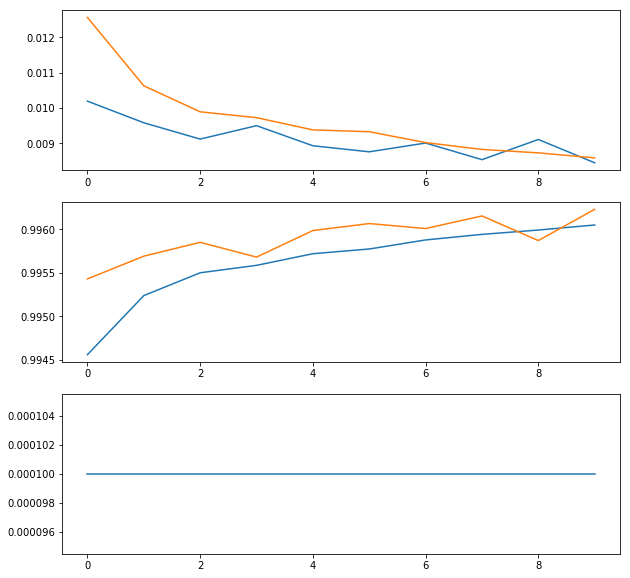

In [31]:
plt.figure(figsize=(10, 10))
plt.subplot(3,1,1)
plt.plot(range(10), history.history['loss'],
         range(10), history.history['val_loss'])
plt.subplot(3,1,2)
plt.plot(range(10), history.history['dice_loss'],
         range(10), history.history['val_dice_loss'])
plt.subplot(3,1,3)
plt.plot(range(10), history.history['lr']);

In [ ]:
max_epochs = 5

callbacks = [EarlyStopping(monitor='val_dice_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4,
                           mode='max'),
             ReduceLROnPlateau(monitor='val_dice_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4,
                               mode='max'),
             ModelCheckpoint(monitor='val_dice_loss',
                             filepath='weights/best_weights_fullres2.hdf5',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')]

history = model.fit_generator(generator=train_generator(train_batch_size),
                    steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(train_batch_size)),
                    epochs=max_epochs,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator(val_batch_size),
                    validation_steps=np.ceil(float(len(ids_valid_split)) / float(val_batch_size)))

Epoch 1/5
4755s - loss: 0.0085 - dice_loss: 0.9961 - val_loss: 0.0085 - val_dice_loss: 0.9961
Epoch 2/5
4770s - loss: 0.0083 - dice_loss: 0.9962 - val_loss: 0.0084 - val_dice_loss: 0.9963
Epoch 3/5
4751s - loss: 0.0083 - dice_loss: 0.9962 - val_loss: 0.0092 - val_dice_loss: 0.9959
Epoch 4/5
4784s - loss: 0.0082 - dice_loss: 0.9962 - val_loss: 0.0083 - val_dice_loss: 0.9963
Epoch 5/5
4780s - loss: 0.0081 - dice_loss: 0.9963 - val_loss: 0.0084 - val_dice_loss: 0.9963


In [33]:
history.history

{'dice_loss': [0.99609746410161326,
  0.99615396379838705,
  0.9961748024023136,
  0.99622358783750042,
  0.99625886428268307],
 'loss': [0.0084647872822739053,
  0.0083404836334123357,
  0.0082724137658468401,
  0.0081692011720278929,
  0.0081006346269297883],
 'lr': [9.9999997e-05,
  9.9999997e-05,
  9.9999997e-05,
  9.9999997e-05,
  9.9999997e-05],
 'val_dice_loss': [0.99613702742196253,
  0.99626036524070039,
  0.99589551876944971,
  0.99630729634541659,
  0.99631929608365644],
 'val_loss': [0.0085428459130681336,
  0.0084342336563909444,
  0.0092407378014945571,
  0.008318381248616516,
  0.0083795360276706088]}

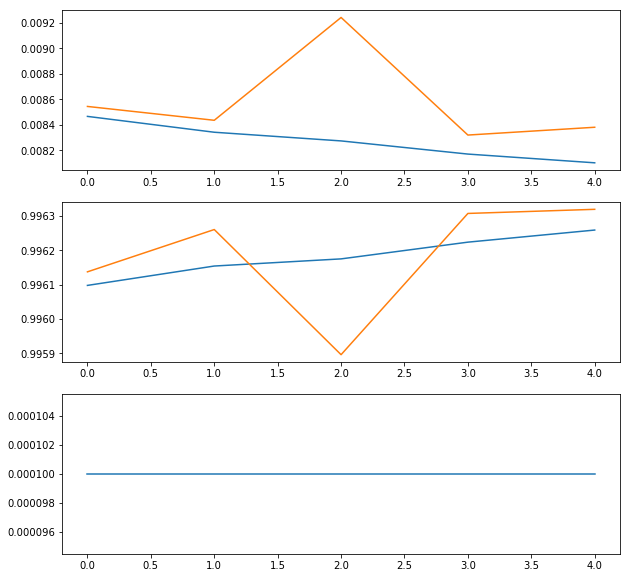

In [35]:
plt.figure(figsize=(10, 10))
plt.subplot(3,1,1)
plt.plot(range(5), history.history['loss'],
         range(5), history.history['val_loss'])
plt.subplot(3,1,2)
plt.plot(range(5), history.history['dice_loss'],
         range(5), history.history['val_dice_loss'])
plt.subplot(3,1,3)
plt.plot(range(5), history.history['lr']);

# Predictions

In [8]:
from tqdm import tqdm

In [9]:
df_test = pd.read_csv('data/sample_submission.csv')
ids_test = df_test['img'].map(lambda s: s.split('.')[0])

In [10]:
names = []
for id in ids_test:
    names.append('{}.jpg'.format(id))

In [11]:
# https://www.kaggle.com/stainsby/fast-tested-rle
def run_length_encode(mask):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    inds = mask.flatten()
    runs = np.where(inds[1:] != inds[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    rle = ' '.join([str(r) for r in runs])
    return rle


rles = []

In [12]:
model.load_weights(filepath='weights/best_weights_fullres2.hdf5')

In [13]:
val_batch_size = 8
threshold = 0.5

In [ ]:
import gzip
import pickle
f = gzip.open('test_bboxes.pklz','rb')
test_bboxes = pickle.load(f)
f.close()

In [ ]:
print('Predicting on {} samples with batch_size = {}...'.format(len(ids_test), val_batch_size))
for start in tqdm(range(0, len(ids_test), val_batch_size)):
    
    x_batch = []
    end = min(start + val_batch_size, len(ids_test))
    ids_test_batch = ids_test[start:end]
    
    for id in ids_test_batch.values:
        img = cv2.imread('data/test/{}.jpg'.format(id))
        
        this_bbox = test_bboxes[id]
        img_1_box = this_bbox[0]
        img_2_box = this_bbox[1]
        
        img_1 = np.copy(img[img_1_box[2]:(img_1_box[3]+1), img_1_box[0]:(img_1_box[1]+1),:])
        img_2 = np.copy(img[img_2_box[2]:(img_2_box[3]+1), img_2_box[0]:(img_2_box[1]+1),:])
        img_2 = cv2.flip(img_2, 1)
        
        x_batch.append(img_1)
        x_batch.append(img_2)
    
    x_batch = np.array(x_batch, np.float32) / 255
    preds = model.predict_on_batch(x_batch)
    preds = np.squeeze(preds, axis=3)
    
    final_preds = []
    for i in range(len(ids_test_batch.values)):
        id = ids_test_batch.values[i]
        
        this_bbox = test_bboxes[id]
        img_1_box = this_bbox[0]
        img_2_box = this_bbox[1]
        
        pred_1 = np.copy(preds[(i*2), :, :])
        pred_2 = np.copy(preds[(i*2) + 1, :, :])
        pred_2 = cv2.flip(pred_2, 1)
        
        left_part   = np.copy(pred_1[:, 0:894])
        middle_1    = np.copy(pred_1[:, 894:1024])
        middle_2    = np.copy(pred_2[:, 0:130])
        middle_part = np.add(middle_1, middle_2)/2
        right_part  = np.copy(pred_2[:, 130:1024])
        all_parts   = np.concatenate((left_part, middle_part, right_part), axis=1)
        
        if img_1_box[2] != 0:
            top_part = np.zeros(shape = (img_1_box[2],1918), dtype = np.float32)
            all_parts = np.concatenate((top_part, all_parts), axis = 0)
            
        if img_1_box[3] != 1279:
            bottom_part = np.zeros(shape = (1279-img_1_box[3],1918), dtype = np.float32)
            all_parts = np.concatenate((all_parts, bottom_part), axis = 0)
        
        final_preds.append(all_parts)
        
    
    for prob in final_preds:
        mask = prob > threshold
        rle = run_length_encode(mask)
        rles.append(rle)

  0%|          | 0/12508 [00:00<?, ?it/s]

Predicting on 100064 samples with batch_size = 8...


 57%|█████▋    | 7171/12508 [6:30:12<4:48:45,  3.25s/it] 

In [17]:
print("Generating submission file...")
df = pd.DataFrame({'img': names, 'rle_mask': rles})
df.to_csv('submit/submission6.csv.gz', index=False, compression='gzip')

Generating submission file...
